# Torch-Uncertainty
- Very useful framework to quickly benchmark UQ methods. 
- Abstracts well the complexity of deterministic, probabilistic and ensemble training procedures. Switching between methods is seamless.
- Good coverage of UQ setups like datasets and metrics.
- Docs are ok, code is easy to read as supplement.
- Built on top of Torch Lighning, so fairly easy to extend if familiar with framework. Conversely, tight coupling with Lighning framework might pose problems for experimentation.


## Components
- DataModules: Loader wrappers that include common augmentation and split options the uncertainty quantification setup
    - Splits: 
        - test: choose test set to be clean a modified version (H for cifar, or R/O/A for imagnet)
        - calibration set: heldout val split for postprocessing 
        - OOD: and out of sample dataset (e.g SVHN for CIFAR)
        - Shifted: An additional corrupted test set ("C" version)
    - Augmentations: Basic (crop, flip), Cutout/Mixup, Auto/RandAugment
        - Common corruptions transforms used in evaluation (blur, noise, etc) can be imported manually
- Models and Methods
    - Base architectures: lenet, mlps, vggs, resnet variations, semseg
    - Layers: Distributions (wrapper around a linear layer outputting parameters of a distribution), 
        - Method specific: Bayesian, PackedEnsembles, MaskedEnsembles, BatchedEnsembles
    - Methods: Bayesian networks, Deep Evidential Learning, MCDropout, Batch Ensembles, Packed Ensembles
    - Optim Recipes: helpful optimiser and scheduler presets for common architectures and datasets
- Metrics: Torchmetrics wrappers and extensions that add plotting or differentiablility 
- Routines: A Lightning Module wrapper to handle UQ specific scenarios like multi set evaluation and ensembling
    - Classification, Regression, Segmentation Routines
- Trainer: Light wrapper around Lighning Trainer to handle the engine and training loop.

# Basic Usage

In [188]:
from torch import nn, optim
from torch_uncertainty.models.resnet import resnet
from torch_uncertainty.optim_recipes import optim_cifar10_resnet18
from torch_uncertainty.datamodules import CIFAR100DataModule
from torch_uncertainty.routines import ClassificationRoutine
from torch_uncertainty import TUTrainer


dm = CIFAR100DataModule(
    root="/data/datasets/CIFAR100", 
    batch_size=32,
    eval_ood=True, # SVHN
    eval_shift=True, # CIFAR100C
    shift_severity=1,
    postprocess_set="val"
)

model = resnet(in_channels=3, num_classes=dm.num_classes, arch=18, style="cifar", conv_bias=False)

routine = ClassificationRoutine(
  model,
  is_ensemble=False,
  num_classes=dm.num_classes,
  loss=nn.CrossEntropyLoss(),
  optim_recipe=optim_cifar10_resnet18(model), # SGD + StepLR
  eval_ood=True, # SVHN
  eval_shift=True, # CIFAR100C
)

trainer = TUTrainer(accelerator="gpu", max_epochs=100)
trainer.fit(routine, dm)
trainer.test(routine, dm)

/home/xapharius/work/libs/miniconda3/envs/phd/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `FPR95` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: /data/datasets/CIFAR100/test_32x32.mat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type             | Params | Mode 
----------------------------------------------------------------
0 | model              | _ResNet          | 11.2 M | train
1 | loss               | CrossEntropyLoss | 0      | train
2 | format_batch_fn    | Identity         | 0      | train
3 | val_cls_metrics    | MetricCollection | 0      | train
4 | test_cls_metrics   | MetricCollection | 0      | train
5 | test_id_entropy    | Entropy          | 0      | train
6 | test_ood_metrics   | MetricCollection | 0      | train
7 | test_ood_entropy   | Entropy          | 0      | train
8 | test_shift_metrics | MetricCollection | 0      | train
9 | mixup              | Identity         | 0      | train
----------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.881    Total estimated model params size (MB)
113       Modules in train mode
0         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/xapharius/work/libs/miniconda3/envs/phd/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


/home/xapharius/work/libs/miniconda3/envs/phd/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 1563/1563 [00:35<00:00, 43.51it/s, v_num=173, train_loss=0.0647, Acc%=75.20] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1563/1563 [00:36<00:00, 43.27it/s, v_num=173, train_loss=0.0647, Acc%=75.20]
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: /data/datasets/CIFAR100/test_32x32.mat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/xapharius/work/libs/miniconda3/envs/phd/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


Testing DataLoader 2: 100%|██████████| 5938/5938 [00:43<00:00, 136.23it/s]


┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃      Classification       ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Acc      │          75.180%          │
│    Brier     │          0.36263          │
│   Entropy    │          0.49599          │
│     NLL      │          1.05046          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃        Calibration        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ECE      │          0.10412          │
│     aECE     │          0.10411          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃       OOD Detection       ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     AUPR     │          90.534%          │
│    AUROC     │          82.707%          │
│   Entropy    │          1.61608          │
│    FPR95     │          49.110%          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃ Selective Classification  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    AUGRC     │          5.441%           │
│     AURC     │          6.988%           │
│  Cov@5Risk   │          55.050%          │
│  Risk@80Cov  │          14.288%          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃  Distribution Shift lvl1  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    AUGRC     │          10.538%          │
│     AURC     │          14.430%          │
│     Acc      │          62.774%          │
│    Brier     │          0.53686          │
│  Cov@5Risk   │           nan%            │
│     ECE      │          0.16364          │
│     NLL      │          1.73825          │
│  Risk@80Cov  │          27.261%          │
│     aECE     │          0.16357          │
└──────────────┴───────────────────────────┘

[{'test/cal/ECE': 0.10411842912435532,
  'test/cal/aECE': 0.10411345958709717,
  'test/cls/Acc': 0.751800000667572,
  'test/cls/Brier': 0.36263296008110046,
  'test/cls/NLL': 1.050455093383789,
  'test/sc/AUGRC': 0.05441368743777275,
  'test/sc/AURC': 0.06987723708152771,
  'test/sc/Cov@5Risk': 0.5505000352859497,
  'test/sc/Risk@80Cov': 0.14287500083446503,
  'test/cls/Entropy': 0.49598994851112366,
  'ood/AUPR': 0.9053370952606201,
  'ood/AUROC': 0.8270742893218994,
  'ood/FPR95': 0.491100013256073,
  'shift/cal/ECE': 0.1636355221271515,
  'shift/cal/aECE': 0.1635722666978836,
  'shift/cls/Acc': 0.6277421116828918,
  'shift/cls/Brier': 0.5368635058403015,
  'shift/cls/NLL': 1.738254427909851,
  'shift/sc/AUGRC': 0.10538056492805481,
  'shift/sc/AURC': 0.1443038433790207,
  'shift/sc/Cov@5Risk': nan,
  'shift/sc/Risk@80Cov': 0.2726118564605713,
  'shift/shift_severity': 1.0},
 {'ood/Entropy': 1.616075038909912,
  'ood/AUPR': 0.9053370952606201,
  'ood/AUROC': 0.8270742893218994,
  'oo

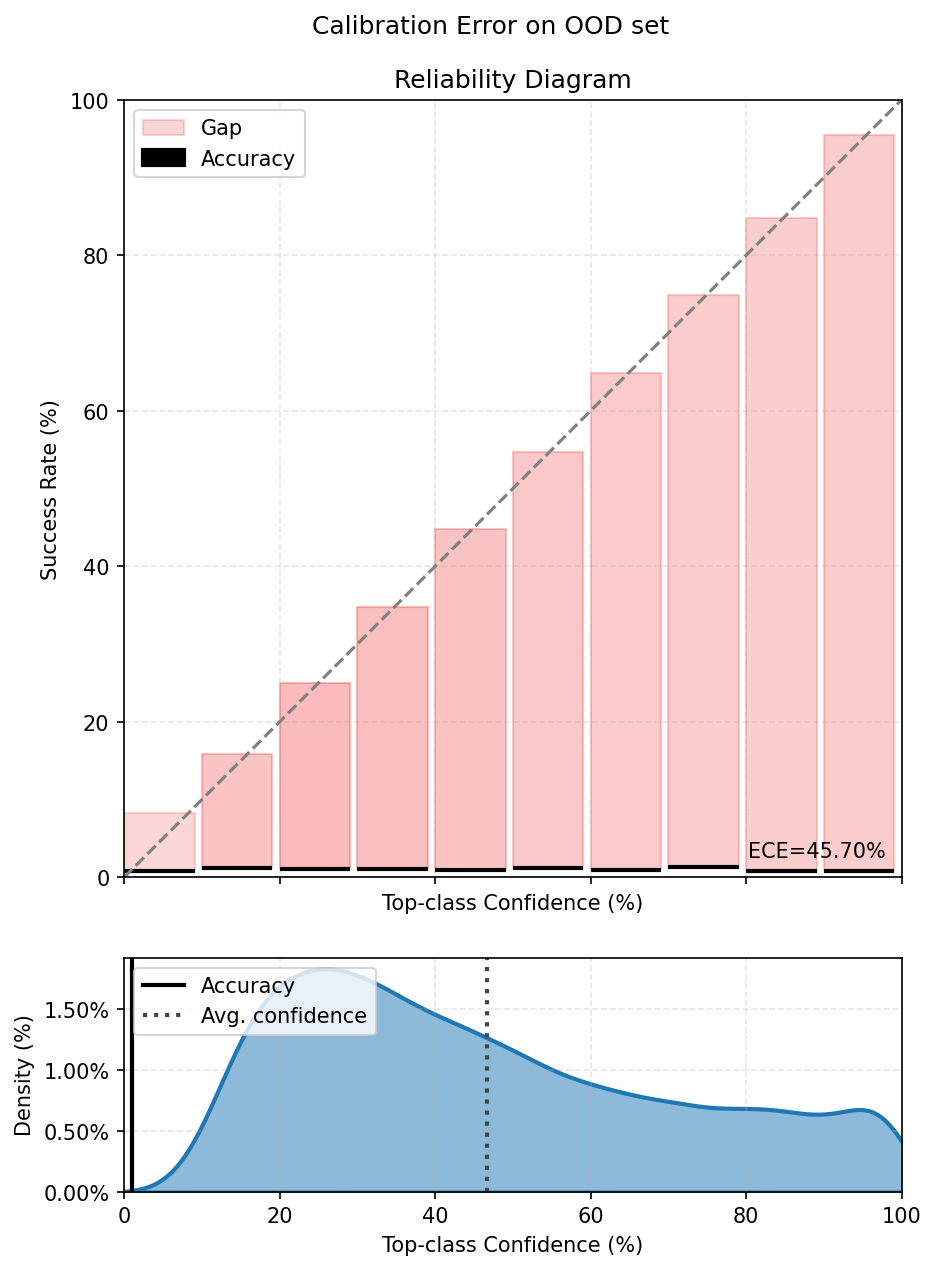

In [189]:
# Manual Evaluation
from torch_uncertainty.metrics import CalibrationError

ece = CalibrationError(task="multiclass", num_classes=dm.num_classes)

for sample, target in trainer.test_dataloaders[1]: # test, OOD, shifted
    logits = routine.model(sample)
    probs = logits.softmax(-1)
    ece.update(probs, target)

fig, ax = ece.plot()
fig.suptitle(f"Calibration Error on OOD set")
fig.show()

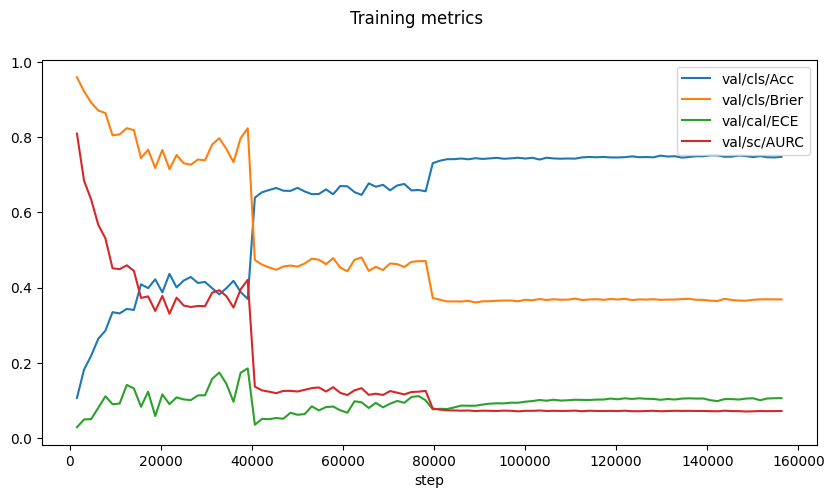

In [80]:
from matplotlib import pyplot as plt
from tbparse import SummaryReader

reader = SummaryReader(trainer.logger.log_dir)
df = reader.scalars

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle("Training metrics")
for metric in [
    "val/cls/Acc",
    "val/cls/Brier",
    "val/cal/ECE",
    "val/sc/AURC",
]:
    df.loc[df["tag"] == metric].set_index("step")["value"].plot(label=metric, ax=ax)
plt.legend()


# UQ Baselines
CIFAR100 using ResNet18. Instead of standard SGD schedule used Adam(1e-4) and Cosine Annealing, so that evidential can somewhat work.
- Baseline: Model before temp scaling. Clear issues with calibration, while classification performance (Acc and AUROC) are not affected by temp scaling.
- Temp Scaling: Requires held out calibration set (here val). Generalisation (in terms of calibration) performance depends on similarity between postprocessing set and test/ood/shifted. In this case it works reasonably well.
- Evidential: Quite ticky to train, SGD(1e-1)+Step doens't work, needs softer lr. Even with Adam(1e-4) doens't really work that well.
- MC Dropout: Solid performance, similar to Ensembling, while compute and memory efficient.
- Ensembling: Best classification performance and good calibration, but at a linear resource cost.

In [ ]:
def get_optim(model):
    optimiser = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=100)
    return {"optimizer": optimiser, "lr_scheduler": scheduler}

def get_routine(model, **kwargs):
    return ClassificationRoutine(
        model,
        num_classes=dm.num_classes,
        # optim_recipe=optim_cifar10_resnet18(model), # SGD + StepLR
        optim_recipe=get_optim(model), # Low lr adam for evidential to work
        eval_ood=True, # SVHN
        eval_shift=True, # CIFAR100C
        **kwargs,
    )
routines = {}

## Temperature scaling
from torch_uncertainty.post_processing import TemperatureScaler
model = resnet(in_channels=3, num_classes=dm.num_classes, arch=18, style="cifar", conv_bias=False)
routines["Temp Scaling"] = get_routine(model, loss=nn.CrossEntropyLoss(), post_processing=TemperatureScaler(device="cuda:0"))

## Evidential 
from torch_uncertainty.losses import DECLoss
model = resnet(in_channels=3, num_classes=dm.num_classes, arch=18, style="cifar", conv_bias=False)
routines["Evidential"] = get_routine(model, loss=DECLoss(reg_weight=1e-2))

## MC Dropout
from torch_uncertainty.models import mc_dropout
model = mc_dropout(resnet(in_channels=3, num_classes=dm.num_classes, arch=18, style="cifar", conv_bias=False, dropout_rate=0.1), num_estimators=16, last_layer=False)
routines["MC Dropout"] = get_routine(model, loss=nn.CrossEntropyLoss(), is_ensemble=True)

## Deep Ensemble
from torch_uncertainty.models import deep_ensembles
from torch_uncertainty.transforms import RepeatTarget
model = deep_ensembles(resnet(in_channels=3, num_classes=dm.num_classes, arch=18, style="cifar", conv_bias=False), num_estimators=3, reset_model_parameters=True)
routines["Ensemble"] = get_routine(model, loss=nn.CrossEntropyLoss(), is_ensemble=True, format_batch_fn=RepeatTarget(3),)

results = {}
for method, routine in routines.items():
    trainer = TUTrainer(accelerator="gpu", max_epochs=100, devices=[0])
    trainer.fit(routine, dm)
    if method == "Temp Scaling":
        results["Baseline"] = trainer.test(routine, dm) # runs without post-processing
        routine.model = routine.post_processing
        results["Temp Scaling"] = trainer.test(routine, dm)
    else:
        results[method] = trainer.test(routine, dm)

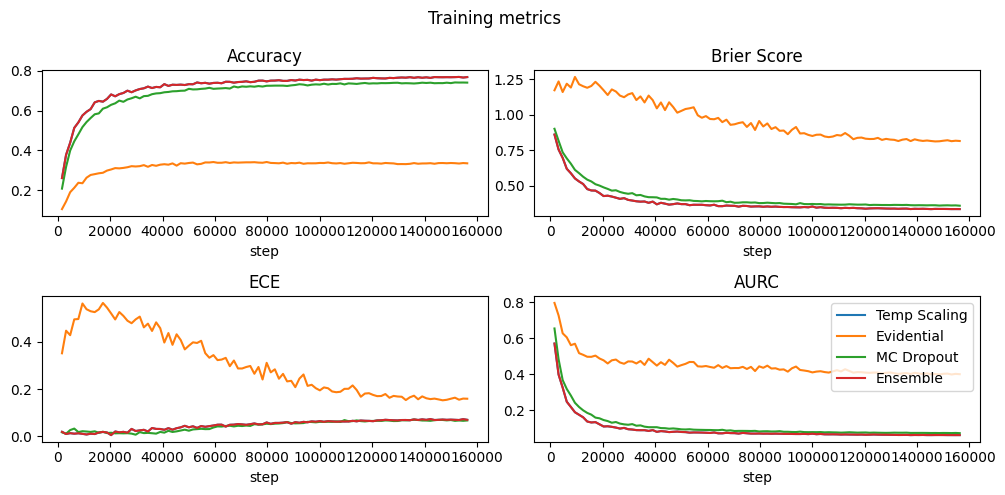

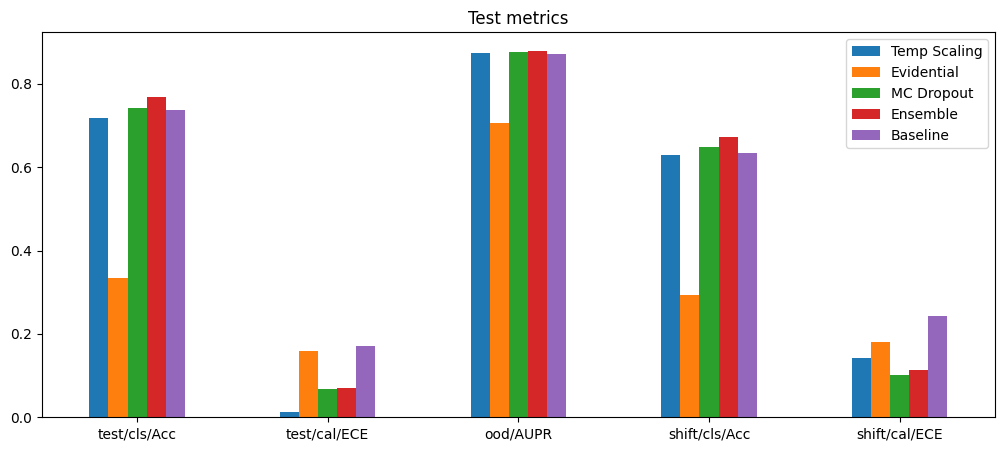

,Temp Scaling,Evidential,MC Dropout,Ensemble,Baseline
test/cls/Acc,0.718300,0.334800,0.742000,0.769300,0.737500
test/cal/ECE,0.013314,0.159212,0.067211,0.070083,0.170478
ood/AUPR,0.874887,0.706908,0.875638,0.879486,0.871902
shift/cls/Acc,0.629176,0.293916,0.647142,0.672221,0.634711
shift/cal/ECE,0.141275,0.180934,0.102490,0.114127,0.242768


In [184]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle("Training metrics")
for name, routine in routines.items():
    reader = SummaryReader(routine.logger.log_dir)
    df = reader.scalars
    df.loc[df["tag"] == "val/cls/Acc"].set_index("step")["value"].plot(label=name, ax=axarr[0][0], title="Accuracy")
    df.loc[df["tag"] == "val/cls/Brier"].set_index("step")["value"].plot(label=name, ax=axarr[0][1], title="Brier Score")
    df.loc[df["tag"] == "val/cal/ECE"].set_index("step")["value"].plot(label=name, ax=axarr[1][0], title="ECE")
    df.loc[df["tag"] == "val/sc/AURC"].set_index("step")["value"].plot(label=name, ax=axarr[1][1], title="AURC")
plt.tight_layout()
plt.legend()
plt.show()

metrics = ["test/cls/Acc", "test/cal/ECE", "ood/AUPR", "shift/cls/Acc", "shift/cal/ECE"]
df = pd.DataFrame({method: result[0] for method, result in results.items()}).loc[metrics]
df.plot.bar(figsize=(12.3, 5), title="Test metrics")
plt.xticks(rotation=0)
plt.show()

display(df)